In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir('/content/gdrive/My Drive/Thesis/')
!pwd

/content/gdrive/My Drive/Thesis


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.Data Preprocessing

In [4]:
data = pd.read_csv('final-data/aspect-extraction.csv')
data.head()

,reviews,label,convenience,payment_integration,accessibility,security_privacy,customer_support,technical_issues,updates,fraud,promotion,functionality
0,tại_sao ngân_hàng vpbank e đang liên_kết với m...,Negative,0,1,0,0,0,1,0,0,0,0
1,nạp tiền lỗi đợi ngày mới đc xong rút_tiền cũn...,Negative,0,1,0,0,0,1,0,0,0,0
2,quá tốt khong gì để chê,Positive,1,0,0,0,0,0,0,0,0,0
3,ok,Positive,1,0,0,0,0,0,0,0,0,0
4,lag quá,Negative,0,0,0,0,0,1,0,0,0,0


In [5]:
data.shape

(49305, 12)

In [6]:
data['label'].value_counts()

,count
label,
Negative,30498
Positive,9629
Neutral,9178


####  Neural Network: Bi-LSTM + Bi-GRU

In [7]:
aspects = ['convenience', 'payment_integration', 'accessibility', 'security_privacy', 'customer_support', 'technical_issues', 'updates', 'fraud', 'promotion', 'functionality']

In [8]:
df_train = pd.read_csv("final-data/train_data.csv")
df_val = pd.read_csv("final-data/val_data.csv")
df_test = pd.read_csv("final-data/test_data.csv")

In [9]:
df_train['tokenized_text'] = [word.split() for word in df_train['reviews']]
df_val['tokenized_text'] = [word.split() for word in df_val['reviews']]
df_test['tokenized_text'] = [word.split() for word in df_test['reviews']]

In [10]:
# Define list of bad_words that need to removed
bad_words = ['clm', 'dell', 'vc', 'cc', 'vcl', 'vl', 'lol', 'loz', 'l', 'mọe','đm', 'dm', 'zl', 'Dubadeomemay', 'qq', 'má', 'mẹ']

In [11]:
# Define a word_list dictionary

replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'hk': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương', 'éo':'không', 'méo':'không',

    'sz': 'size', 'wa': 'quá', 'wá': 'quá', 'qá': 'quá', 'lk' : 'liên kết',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được', 'dx': 'được', 'ngta':'người ta',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất', 'cx' : 'cũng',
    'tk': 'tài khoản', 'mk': 'mật khẩu', 'CCCCD': 'căn cước công dân', 'CMND':'chứng minh nhân dân',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'gút': 'tốt', 'tot': 'tốt',
    'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu', 'dell': 'không', 'đell':'không', 'j':'gì', 'đou':'đâu', 'dou':'đâu', 'ngu':'tệ',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài', 'như cức':'tệ', 'ch':'chưa', 'xog':'xong',

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực', '...':'tiêu cực'
}

In [12]:
# Function to replace words using the replace_list dictionary and filter out bad words

def normalize_acronyms(word_list):
    normalized_words = []
    for word in word_list:
        # Replace word if it exists in the replace_list dictionary
        replaced_word = replace_list.get(word, word)
        # Check if the replaced word is not a bad word
        if replaced_word.lower() not in bad_words:
            normalized_words.append(replaced_word)
    return normalized_words

In [13]:
df_train['tokenized'] = df_train['tokenized_text'].apply(normalize_acronyms)
df_val['tokenized'] = df_val['tokenized_text'].apply(normalize_acronyms)
df_test['tokenized'] = df_test['tokenized_text'].apply(normalize_acronyms)

### 2.Word Embeddings

In [14]:
import tensorflow as tf
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train['tokenized'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size:", vocab_size)

Vocab size: 12225


In [15]:
from keras.utils import to_categorical

# Convert training text to sequences
train_sequences = tokenizer.texts_to_sequences(df_train['reviews'])

# Convert numerical labels to one-hot encoded format
train_labels = np.array(df_train[aspects])

In [16]:
np.array(df_train[aspects])

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
from keras.preprocessing.sequence import pad_sequences
train_padded = pad_sequences(train_sequences, maxlen=128, padding = "post", truncating= "post")

In [18]:
val_sequences = tokenizer.texts_to_sequences(df_val['reviews'])

# Convert numerical labels to one-hot encoded format
val_labels = np.array(df_val[aspects])
val_padded = pad_sequences(val_sequences, maxlen=128, padding = "post", truncating= "post")

In [19]:
test_sequences = tokenizer.texts_to_sequences(df_test['reviews'])
test_padded = pad_sequences(test_sequences, maxlen=128, padding = "post", truncating= "post")
# Convert numerical labels to one-hot encoded format
test_labels = np.array(df_test[aspects])

#### 2.1 Pre-trained Word2Vec

In [47]:
from gensim.models import KeyedVectors

# Embedding from the pre-trained word2vec for vietnamese with high dimension (400)
model_path = 'word-embeddings/wiki.vi.model.bin.gz'

# Load Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Evaluate model
print(word2vec_model['vua'])

[-1.9089703e-02 -1.0274482e+00  2.4168384e+00 -1.5118515e+00
  7.6995313e-01 -7.1992278e-01  2.2680235e+00  1.6344090e-01
 -6.5538973e-01 -1.7606641e-01 -2.1672220e+00  1.0844519e+00
  5.8902782e-01 -3.1713593e+00 -1.5832441e+00  2.4540212e+00
  9.8974836e-01  3.5669360e+00  1.6768531e+00  1.0887100e+00
  4.6755064e-01  2.1929963e-01 -3.1871924e+00 -4.9475431e-01
  1.1419570e+00  2.5548004e-02 -1.0594604e+00 -1.5461501e+00
  9.3282270e-01 -1.9767080e-01  2.5773022e-01  1.0612152e+00
 -2.8368831e+00  5.6920916e-01 -4.1389370e-01 -8.4427458e-01
 -1.6499439e+00 -4.5864597e-01  6.0332179e-01  1.4864769e+00
 -1.6011907e+00 -1.2348362e+00 -1.2807351e-01  1.2173928e+00
  4.2736840e-01  3.8601875e-01 -2.3616999e-01  3.4899980e-01
  8.8781603e-02 -2.5281391e-01  3.0634644e+00  7.6760650e-01
 -6.6769287e-02 -7.4099249e-01 -2.0251279e+00 -1.9077170e+00
  5.4520446e-01 -2.6539716e-01  4.7804603e-01  1.9447443e-01
  5.0691527e-01 -2.4890852e+00 -1.5474483e+00 -2.8476837e+00
 -2.2754204e+00 -1.63977

In [48]:
# Create embedding matrix

embedding_dim = word2vec_model.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        embedding_matrix[i] = np.zeros(embedding_dim)

#### 2.2 Word2Vec on dataset

In [31]:
from gensim.models import Word2Vec

# Train Word2Vec model
embedding_dim = 50
model = Word2Vec(sentences=df_train['tokenized'], vector_size=embedding_dim, window=5, min_count=1, sg=1)

# Save the model
model.save("word-embeddings/word2vec_vietnamese_50_dim.model")

In [32]:
# Load the trained model
model = Word2Vec.load("word-embeddings/word2vec_vietnamese_50_dim.model")

# Get the embedding vector for a word
word = "máy"
if word in model.wv:
    embedding_vector = model.wv[word]
    print(f"Embedding vector for '{word}': {embedding_vector}")
else:
    print(f"Word '{word}' not in vocabulary.")

Embedding vector for 'máy': [ 0.3904221   0.49148646 -0.01853165 -0.05860793  0.2226179  -0.4636169
 -0.07282713  0.87522435  0.03063294 -0.05631608 -0.5226975   0.2290588
 -0.01889916 -0.4308238  -0.41620865  0.23234788 -0.5503341  -0.0490737
  0.01841769 -0.8787578   0.38964105 -0.21058378  1.0055065  -0.04555743
  0.87109655  0.67262197 -0.08600719 -0.0214496  -0.22391774  0.18637277
  0.25452706 -0.01809136  0.37190792 -0.26449636 -0.05544621  0.95195407
  0.8546986   0.9357264   0.07110885 -0.6962635   0.39967018  0.8464342
  0.4776923   0.76969665  0.783102    0.06910267 -0.5065169  -0.22300869
  0.25509742 -0.20671038]


In [33]:
# Create the embedding matrix
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]
    else:
        embedding_matrix[i] = np.zeros(embedding_dim)

### 3.1 Bi-LSTM and Bi-GRU (Pre-trained Word2Vec)

In [49]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, MaxPooling1D, LayerNormalization, Dropout, GlobalMaxPooling1D, Dense, Concatenate
from keras.initializers import GlorotNormal
from keras.models import Model
from keras.optimizers import Adam

def LSTM_and_GRU_model():
    input_layer = Input(shape=(128,))
    vocab_size = 12225
    feature = Embedding(input_dim=vocab_size, output_dim=400, weights=[embedding_matrix], embeddings_initializer=GlorotNormal())(input_layer)

    # LSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    lstm_pooling = MaxPooling1D()(lstm_layer)
    lstm_normalized = LayerNormalization()(lstm_pooling)
    lstm_global_max_pool = GlobalMaxPooling1D()(lstm_normalized)

    # GRU layer
    gru_layer = Bidirectional(GRU(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    gru_pooling = MaxPooling1D()(gru_layer)
    gru_normalized = LayerNormalization()(gru_pooling)
    gru_global_max_pool = GlobalMaxPooling1D()(gru_normalized)

    combined = Concatenate()([lstm_global_max_pool, gru_global_max_pool])

    # Shared dropout and pooling layers
    shared = Dropout(0.2)(combined)

    # Aspect Extraction classifier
    aspect_clf = Dense(32, activation='relu')(shared)
    aspect_clf = Dropout(0.2)(aspect_clf)
    aspect_output = Dense(10, activation='sigmoid', name='aspect')(aspect_clf)

    # Model with two outputs
    model = Model(inputs=input_layer, outputs=aspect_output)

    return model

In [50]:
model = LSTM_and_GRU_model()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','binary_accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 128, 400)       │      4,890,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 128, 128)       │        238,080 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 128, 128)       │        178,944 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 64, 128)        │              0 │ bidirectional_4[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 64, 128)        │              0 │ bidirectional_5[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 64, 128)        │            256 │ max_pooling1d_4[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 64, 128)        │            256 │ max_pooling1d_5[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 128)            │              0 │ layer_normalization_4… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_5    │ (None, 128)            │              0 │ layer_normalization_5… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          8,224 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ aspect (Dense)       

 Total params: 5,316,090 (20.28 MB)

 Trainable params: 5,316,090 (20.28 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_padded, train_labels, epochs=20, verbose=1, shuffle=True,
                    validation_data=(val_padded, val_labels), callbacks=[early_stopping])

Epoch 1/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 67s 51ms/step - accuracy: 0.5859 - binary_accuracy: 0.8803 - loss: 0.2895 - val_accuracy: 0.7150 - val_binary_accuracy: 0.9749 - val_loss: 0.0774
Epoch 2/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - accuracy: 0.7272 - binary_accuracy: 0.9656 - loss: 0.0988 - val_accuracy: 0.7172 - val_binary_accuracy: 0.9831 - val_loss: 0.0553
Epoch 3/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.7176 - binary_accuracy: 0.9745 - loss: 0.0749 - val_accuracy: 0.7249 - val_binary_accuracy: 0.9848 - val_loss: 0.0488
Epoch 4/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.7221 - binary_accuracy: 0.9780 - loss: 0.0638 - val_accuracy: 0.7116 - val_binary_accuracy: 0.9856 - val_loss: 0.0465
Epoch 5/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.7233 - binary_accuracy: 0.9804 - loss: 0.0581 - val_accuracy: 0.7087 - val_binary_accuracy: 0.9866 - val_loss: 0.0441
Epoch 6/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - ac

In [52]:
from sklearn.metrics import classification_report

aspects = ['convenience', 'payment_integration','accessibility', 'security_privacy', 'customer_support', 'technical_issues', 'updates', 'fraud', 'promotion', 'functionality']
# Predict on the test data
predictions = model.predict(test_padded)

# Get predictions for aspect extraction
y_aspect_pred = (predictions > 0.5).astype(int)
y_aspect_true = test_labels

print("Aspect Extraction Classification Report:")
print(classification_report(y_aspect_true, y_aspect_pred, target_names=aspects))

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Aspect Extraction Classification Report:
                     precision    recall  f1-score   support

        convenience       0.94      0.89      0.91      1292
payment_integration       0.99      0.97      0.98      2882
      accessibility       0.99      0.96      0.97       920
   security_privacy       0.93      0.73      0.82       203
   customer_support       0.99      0.94      0.96       272
   technical_issues       0.99      0.98      0.98      1654
            updates       0.99      1.00      1.00       186
              fraud       0.99      0.97      0.98       155
          promotion       1.00      0.99      1.00       177
      functionality       0.99      0.98      0.98       276

          micro avg       0.98      0.95      0.96      8017
          macro avg       0.98      0.94      0.96      8017
       weighted avg       0.98      0.95      0.96      8017
        samples avg       0.97      0.96      0.96      8017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):

    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []

    for i in range(y_true.shape[0]):

        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )

        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))

        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred)) /   float(len(set_true.union(set_pred)))

        #print('tmp_a: {0}'.format(tmp_a))

        acc_list.append(tmp_a)

    return np.mean(acc_list)

In [54]:
from sklearn.metrics import log_loss, precision_recall_fscore_support, accuracy_score

print("Macro Precision/Recall/F1-Score:", precision_recall_fscore_support(test_labels, y_aspect_pred, average='macro'))
print("Accuracy:",accuracy_score(test_labels, y_aspect_pred))
print("Hamming score:",hamming_score(test_labels, y_aspect_pred))

Macro Precision/Recall/F1-Score: (0.9800686305681543, 0.941205814676145, 0.9592681226483408, None)
Accuracy: 0.9083350233218415
Hamming score: 0.9504611254357755


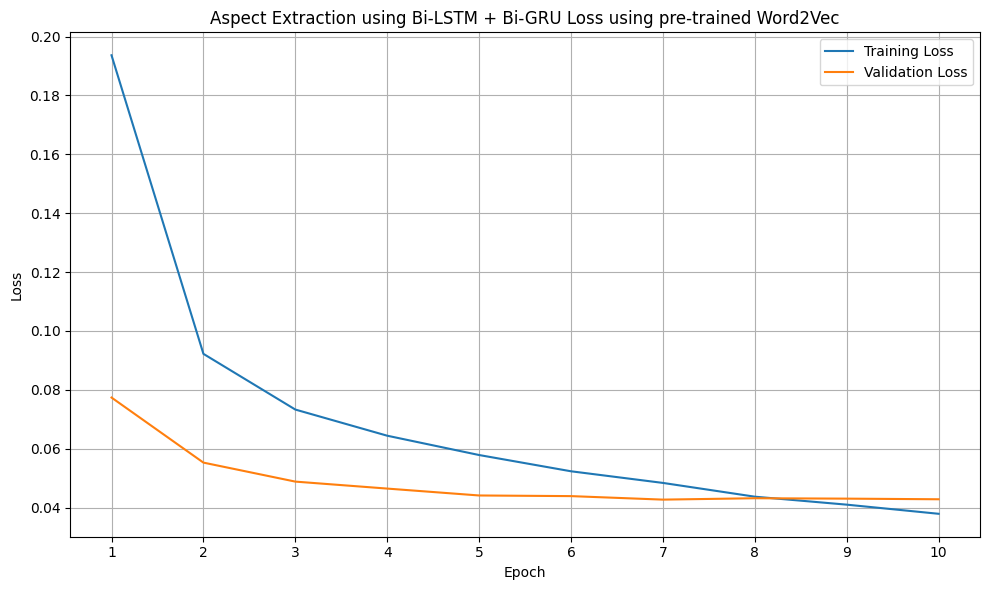

In [55]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Aspect Extraction using Bi-LSTM + Bi-GRU Loss using pre-trained Word2Vec')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Set epoch ticks as integers
plt.xticks(epochs)
plt.tight_layout()
plt.show()

In [62]:
model.save("final-models/aspect-extraction-400dim-18August.h5")

### 3.2 Bi-LSTM and Bi-GRU (Word2Vec on the training data)

In [34]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, MaxPooling1D, LayerNormalization, Dropout, GlobalMaxPooling1D, Dense, Concatenate
from keras.initializers import GlorotNormal
from keras.models import Model
from keras.optimizers import Adam

def LSTM_and_GRU_model():
    input_layer = Input(shape=(128,))
    vocab_size = 12225
    feature = Embedding(input_dim=vocab_size, output_dim=50, input_length=128, weights=[embedding_matrix], embeddings_initializer=GlorotNormal())(input_layer)

    # LSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    lstm_pooling = MaxPooling1D()(lstm_layer)
    lstm_normalized = LayerNormalization()(lstm_pooling)
    lstm_global_max_pool = GlobalMaxPooling1D()(lstm_normalized)

    # GRU layer
    gru_layer = Bidirectional(GRU(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    gru_pooling = MaxPooling1D()(gru_layer)
    gru_normalized = LayerNormalization()(gru_pooling)
    gru_global_max_pool = GlobalMaxPooling1D()(gru_normalized)

    combined = Concatenate()([lstm_global_max_pool, gru_global_max_pool])

    # Shared dropout and pooling layers
    shared = Dropout(0.2)(combined)

    # Aspect Extraction classifier
    aspect_clf = Dense(32, activation='relu')(shared)
    aspect_clf = Dropout(0.2)(aspect_clf)
    aspect_output = Dense(10, activation='sigmoid', name='aspect')(aspect_clf)

    # Model with two outputs
    model = Model(inputs=input_layer, outputs=aspect_output)

    return model

In [35]:
model = LSTM_and_GRU_model()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','binary_accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 128, 50)        │        611,250 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 128, 128)       │         58,880 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 128, 128)       │         44,544 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 64, 128)        │              0 │ bidirectional_2[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 64, 128)        │              0 │ bidirectional_3[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 128)        │            256 │ max_pooling1d_2[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 64, 128)        │            256 │ max_pooling1d_3[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 128)            │              0 │ layer_normalization_2… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 128)            │              0 │ layer_normalization_3… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          8,224 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ aspect (Dense)       

 Total params: 723,740 (2.76 MB)

 Trainable params: 723,740 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_padded, train_labels, epochs=20, verbose=1, shuffle=True,
                    validation_data=(val_padded, val_labels), callbacks=[early_stopping])

Epoch 1/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - accuracy: 0.5746 - binary_accuracy: 0.8783 - loss: 0.2942 - val_accuracy: 0.7600 - val_binary_accuracy: 0.9742 - val_loss: 0.0785
Epoch 2/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.7267 - binary_accuracy: 0.9648 - loss: 0.0997 - val_accuracy: 0.7247 - val_binary_accuracy: 0.9813 - val_loss: 0.0592
Epoch 3/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.7265 - binary_accuracy: 0.9733 - loss: 0.0778 - val_accuracy: 0.7252 - val_binary_accuracy: 0.9848 - val_loss: 0.0484
Epoch 4/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.7373 - binary_accuracy: 0.9788 - loss: 0.0628 - val_accuracy: 0.7661 - val_binary_accuracy: 0.9859 - val_loss: 0.0440
Epoch 5/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7601 - binary_accuracy: 0.9817 - loss: 0.0547 - val_accuracy: 0.8053 - val_binary_accuracy: 0.9870 - val_loss: 0.0428
Epoch 6/20
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - ac

In [37]:
from sklearn.metrics import classification_report

aspects = ['convenience', 'payment_integration','accessibility', 'security_privacy', 'customer_support', 'technical_issues', 'updates', 'fraud', 'promotion', 'functionality']
# Predict on the test data
predictions = model.predict(test_padded)

# Get predictions for aspect extraction
y_aspect_pred = (predictions > 0.5).astype(int)
y_aspect_true = test_labels

print("Aspect Extraction Classification Report:")
print(classification_report(y_aspect_true, y_aspect_pred, target_names=aspects))

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Aspect Extraction Classification Report:
                     precision    recall  f1-score   support

        convenience       0.95      0.88      0.92      1292
payment_integration       0.99      0.97      0.98      2882
      accessibility       0.99      0.97      0.98       920
   security_privacy       0.92      0.77      0.84       203
   customer_support       1.00      0.95      0.97       272
   technical_issues       1.00      0.98      0.99      1654
            updates       1.00      0.98      0.99       186
              fraud       1.00      0.99      0.99       155
          promotion       1.00      0.99      0.99       177
      functionality       1.00      0.99      0.99       276

          micro avg       0.98      0.95      0.97      8017
          macro avg       0.98      0.95      0.96      8017
       weighted avg       0.98      0.95      0.97      8017
        samples avg       0.98      0.96      0.96      8017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
from sklearn.metrics import log_loss, precision_recall_fscore_support, accuracy_score

print("Macro Precision/Recall/F1-Score:", precision_recall_fscore_support(test_labels, y_aspect_pred, average='macro'))
print("Accuracy:",accuracy_score(test_labels, y_aspect_pred))
print("Hamming score:",hamming_score(test_labels, y_aspect_pred))

Macro Precision/Recall/F1-Score: (0.9836529973210559, 0.9462936959382026, 0.9640285275183936, None)
Accuracy: 0.9150273778138308
Hamming score: 0.953423433863507


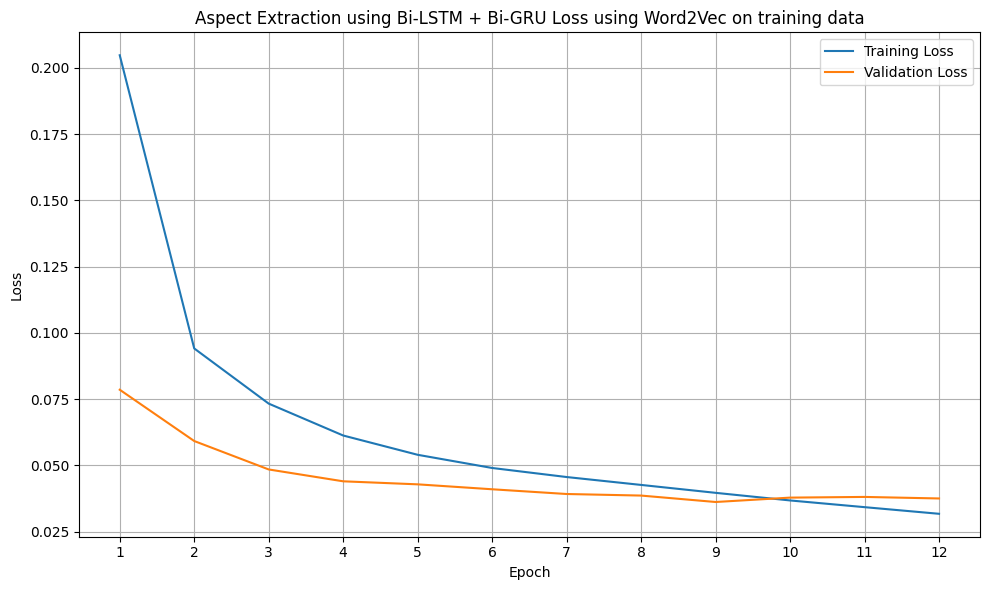

In [39]:
import matplotlib.pyplot as plt

epochs = range(1, 13)
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Aspect Extraction using Bi-LSTM + Bi-GRU Loss using Word2Vec on training data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Set epoch ticks as integers
plt.xticks(epochs)
plt.tight_layout()
plt.show()

In [ ]:
model.save("models/aspect-extraction-50dim-28June.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 3.3 Compared model: Bi-LSTM only

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, GlobalMaxPooling1D, Dense
from keras.initializers import GlorotNormal
from keras.models import Model
from keras.optimizers import Adam

def Bi_LSTM_model():
    input_layer = Input(shape=(128,))
    vocab_size = 12225
    feature = Embedding(input_dim=vocab_size, output_dim=400, input_length=128)(input_layer)

    # LSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True), merge_mode='concat')(feature)
    lstm_global_max_pool = GlobalMaxPooling1D()(lstm_layer)
    aspect_clf = Dense(64, activation='relu')(lstm_global_max_pool)
    aspect_clf = Dropout(0.2)(aspect_clf)
    aspect_output = Dense(10, activation='sigmoid', name='aspect')(aspect_clf)

    # Model with two outputs
    model = Model(inputs=input_layer, outputs=aspect_output)

    return model

In [ ]:
model = Bi_LSTM_model()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','binary_accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 400)          4890000   
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          238080    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0     

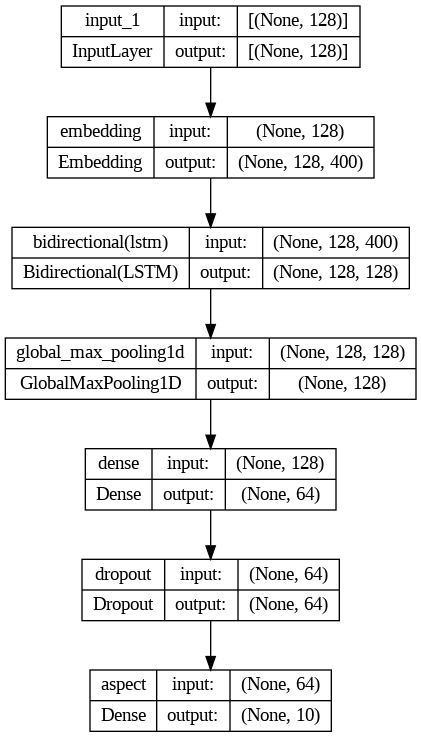

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_padded, train_labels, epochs=25, verbose=1, shuffle=True,
                    validation_data=(val_padded, val_labels), callbacks=[early_stopping])

Epoch 1/25
1233/1233 [==============================] - 83s 61ms/step - loss: 0.1511 - accuracy: 0.7066 - binary_accuracy: 0.9482 - val_loss: 0.0623 - val_accuracy: 0.7763 - val_binary_accuracy: 0.9802
Epoch 2/25
1233/1233 [==============================] - 26s 21ms/step - loss: 0.0554 - accuracy: 0.7303 - binary_accuracy: 0.9826 - val_loss: 0.0430 - val_accuracy: 0.7209 - val_binary_accuracy: 0.9862
Epoch 3/25
1233/1233 [==============================] - 21s 17ms/step - loss: 0.0414 - accuracy: 0.7239 - binary_accuracy: 0.9876 - val_loss: 0.0390 - val_accuracy: 0.6751 - val_binary_accuracy: 0.9880
Epoch 4/25
1233/1233 [==============================] - 22s 18ms/step - loss: 0.0339 - accuracy: 0.7229 - binary_accuracy: 0.9896 - val_loss: 0.0380 - val_accuracy: 0.7442 - val_binary_accuracy: 0.9881
Epoch 5/25
1233/1233 [==============================] - 21s 17ms/step - loss: 0.0285 - accuracy: 0.7282 - binary_accuracy: 0.9913 - val_loss: 0.0392 - val_accuracy: 0.7213 - val_binary_accurac

In [ ]:
from sklearn.metrics import classification_report

aspects = ['convenience', 'payment_integration','accessibility', 'security_privacy', 'customer_support', 'technical_issues', 'updates', 'fraud', 'promotion', 'functionality']
# Predict on the test data
predictions = model.predict(test_padded)

# Get predictions for aspect extraction
y_aspect_pred = (predictions > 0.5).astype(int)
y_aspect_true = test_labels

print("Aspect Extraction Classification Report:")
print(classification_report(y_aspect_true, y_aspect_pred, target_names=aspects))

155/155 [==============================] - 2s 6ms/step
Aspect Extraction Classification Report:
                     precision    recall  f1-score   support

        convenience       0.96      0.88      0.92      1292
payment_integration       0.98      0.97      0.98      2882
      accessibility       0.98      0.97      0.97       920
   security_privacy       0.87      0.78      0.82       203
   customer_support       1.00      0.97      0.98       272
   technical_issues       1.00      0.97      0.98      1654
            updates       1.00      0.98      0.99       186
              fraud       1.00      0.99      1.00       155
          promotion       1.00      1.00      1.00       177
      functionality       0.99      1.00      1.00       276

          micro avg       0.98      0.95      0.97      8017
          macro avg       0.98      0.95      0.96      8017
       weighted avg       0.98      0.95      0.97      8017
        samples avg       0.98      0.96      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import log_loss, precision_recall_fscore_support, accuracy_score

print("Macro Precision/Recall/F1-Score:", precision_recall_fscore_support(test_labels, y_aspect_pred, average='macro'))
print("Accuracy:",accuracy_score(test_labels, y_aspect_pred))
print("Hamming score:",hamming_score(test_labels, y_aspect_pred))

Macro Precision/Recall/F1-Score: (0.9770343390762506, 0.9526556250029238, 0.9644250884744634, None)
Accuracy: 0.914013384708984
Hamming score: 0.9531989068188621


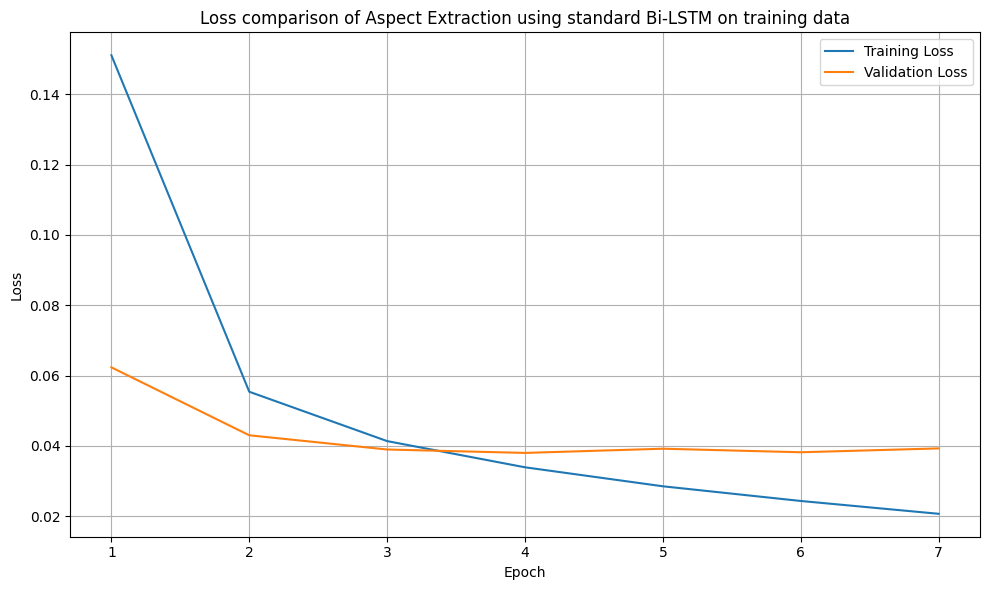

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 8)
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Loss comparison of Aspect Extraction using standard Bi-LSTM on training data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Set epoch ticks as integers
plt.xticks(epochs)
plt.tight_layout()
plt.show()

#### Test on new instances

In [40]:
# Function to get aspect names from binary predictions
def get_aspect_names(binary_preds, aspect_names):
    aspect_list = []
    for i, pred in enumerate(binary_preds[0]):
        if pred == 1:
            aspect_list.append(aspects[i])
    return aspect_list

In [66]:
from keras.models import load_model

# Load the model with both custom loss functions
test_model = load_model('final-models/aspect-extraction-400dim-18August.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 23 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [67]:
# Define the new input text
new_texts = ["Hôm qua cập nhật phần mềm momo xong không vào được.bắt điền sdt với mk xong báo dữ liệu chưa dc cập nhật rồi bị văng ra.bắt đăng nhập lại \
              .mãi ko vào dc.nay vào thì bắt gửi otp xong mãi chả thấy gửi mã.tin nhắn ko gửi.gọi điẹn báo otp cũng ko thấy.làm ăn chán quá"]

# Tokenize the new text
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=128)

# Make predictions on the new text
new_preds = test_model.predict(new_data)
print("Predictions:", new_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Predictions: [[2.2259733e-02 5.3393799e-03 9.9952471e-01 4.6410177e-02 3.1555271e-01
  9.9890625e-01 8.4543335e-01 2.0910724e-05 7.1652378e-03 3.9492915e-03]]


In [68]:
# Set threshold for binary classification is 0.5
new_preds_binary = (new_preds > 0.5).astype(int)
print("Binary Predictions:", new_preds_binary)

# Get the aspect names from binary predictions
predicted_aspects = get_aspect_names(new_preds_binary, aspects)
print("Predicted Aspects:", predicted_aspects)

Binary Predictions: [[0 0 1 0 0 1 1 0 0 0]]
Predicted Aspects: ['accessibility', 'technical_issues', 'updates']


#### Model Training

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, MaxPooling1D, LayerNormalization, Dropout, GlobalMaxPooling1D, Dense, Concatenate
from keras.initializers import GlorotNormal
from keras.models import Model
from keras.optimizers import Adam

def LSTM_and_GRU_model():
    input_layer = Input(shape=(128,))
    vocab_size = 12225
    feature = Embedding(input_dim=vocab_size, output_dim=50, input_length=128, weights=[embedding_matrix], embeddings_initializer=GlorotNormal())(input_layer)

    # LSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    lstm_pooling = MaxPooling1D()(lstm_layer)
    lstm_normalized = LayerNormalization()(lstm_pooling)
    lstm_global_max_pool = GlobalMaxPooling1D()(lstm_normalized)

    # GRU layer
    gru_layer = Bidirectional(GRU(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    gru_pooling = MaxPooling1D()(gru_layer)
    gru_normalized = LayerNormalization()(gru_pooling)
    gru_global_max_pool = GlobalMaxPooling1D()(gru_normalized)

    combined = Concatenate()([lstm_global_max_pool, gru_global_max_pool])

    # Shared dropout and pooling layers
    shared = Dropout(0.2)(combined)

    # Aspect Extraction classifier
    aspect_clf = Dense(32, activation='relu')(shared)
    aspect_clf = Dropout(0.2)(aspect_clf)
    aspect_output = Dense(10, activation='sigmoid', name='aspect')(aspect_clf)

    # Model with two outputs
    model = Model(inputs=input_layer, outputs=aspect_output)

    return model

In [ ]:
model = LSTM_and_GRU_model()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 128, 50)              611250    ['input_3[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 128, 128)             58880     ['embedding_1[0][0]']         
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 128, 128)             44544     ['embedding_1[0][0]']     

In [ ]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_padded, train_labels, epochs=20, verbose=1, shuffle=True,
                    validation_data=(val_padded, val_labels), callbacks=[early_stopping])

Epoch 1/20
1233/1233 [==============================] - 401s 318ms/step - loss: 0.1896 - accuracy: 0.6729 - binary_accuracy: 0.9295 - val_loss: 0.0740 - val_accuracy: 0.7201 - val_binary_accuracy: 0.9760
Epoch 2/20
1233/1233 [==============================] - 395s 320ms/step - loss: 0.0875 - accuracy: 0.7043 - binary_accuracy: 0.9699 - val_loss: 0.0531 - val_accuracy: 0.6842 - val_binary_accuracy: 0.9836
Epoch 3/20
1233/1233 [==============================] - 381s 309ms/step - loss: 0.0688 - accuracy: 0.6888 - binary_accuracy: 0.9766 - val_loss: 0.0476 - val_accuracy: 0.6797 - val_binary_accuracy: 0.9854
Epoch 4/20
1233/1233 [==============================] - 386s 313ms/step - loss: 0.0597 - accuracy: 0.6934 - binary_accuracy: 0.9801 - val_loss: 0.0436 - val_accuracy: 0.6897 - val_binary_accuracy: 0.9866
Epoch 5/20
1233/1233 [==============================] - 386s 313ms/step - loss: 0.0530 - accuracy: 0.7025 - binary_accuracy: 0.9824 - val_loss: 0.0411 - val_accuracy: 0.6856 - val_bina

In [ ]:
print("Cross Entropy Loss:", log_loss(y_test_aspect, y_pred.toarray()))
print("Macro Precision/Recall/F1-Score:", precision_recall_fscore_support(y_test_aspect, y_pred, average='macro'))
print("Accuracy:",accuracy_score(y_test_aspect, y_pred))
print("Hamming score:",hamming_score(test_labels, y_pred.todense()))

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):

    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []

    for i in range(y_true.shape[0]):

        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )

        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))

        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred)) /   float(len(set_true.union(set_pred)))

        #print('tmp_a: {0}'.format(tmp_a))

        acc_list.append(tmp_a)

    return np.mean(acc_list)

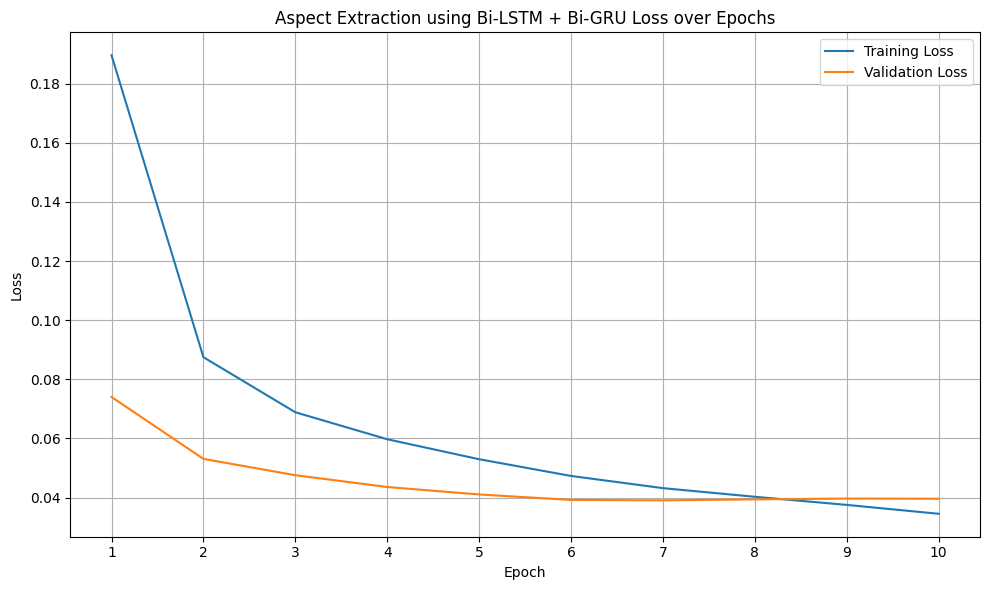

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Aspect Extraction using Bi-LSTM + Bi-GRU Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Set epoch ticks as integers
plt.xticks(epochs)
plt.tight_layout()
plt.show()

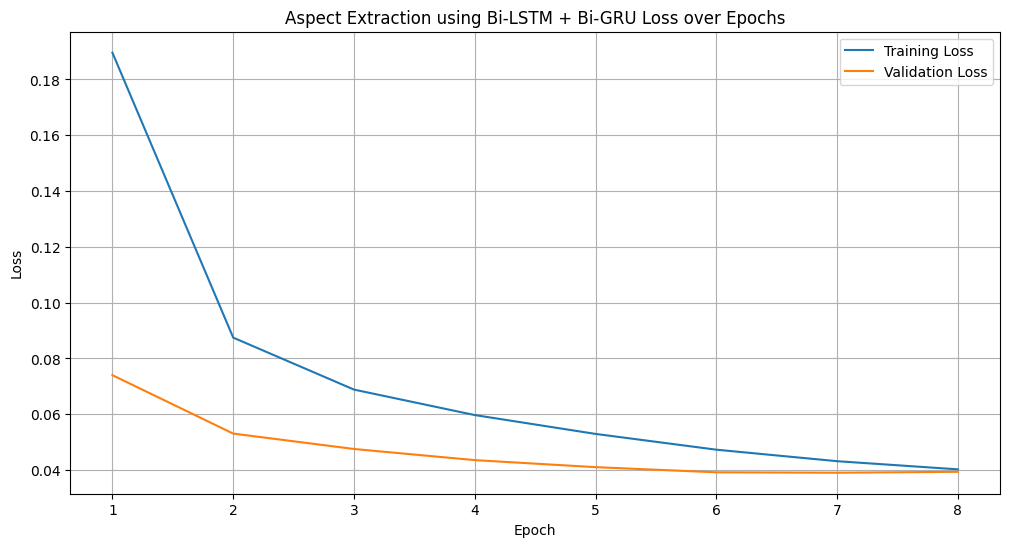

In [ ]:
# Extract the loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Define the number of epochs to plot
epochs = 8

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), training_loss[:epochs], label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss[:epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Aspect Extraction using Bi-LSTM + Bi-GRU Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

aspects = ['convenience', 'payment_integration','accessibility', 'security_privacy', 'customer_support', 'technical_issues', 'updates', 'fraud', 'promotion', 'functionality']
# Predict on the test data
predictions = model.predict(test_padded)

# Get predictions for aspect extraction
y_aspect_pred = (predictions > 0.5).astype(int)
y_aspect_true = y_test_aspect

print("Aspect Extraction Classification Report:")
print(classification_report(y_aspect_true, y_aspect_pred, target_names=aspects))

155/155 [==============================] - 19s 121ms/step
Aspect Extraction Classification Report:
                     precision    recall  f1-score   support

        convenience       0.96      0.88      0.92      1292
payment_integration       0.98      0.97      0.98      2882
      accessibility       0.99      0.96      0.98       920
   security_privacy       0.90      0.78      0.84       203
   customer_support       0.99      0.97      0.98       272
   technical_issues       1.00      0.97      0.98      1654
            updates       1.00      0.98      0.99       186
              fraud       1.00      0.97      0.99       155
          promotion       0.99      1.00      1.00       177
      functionality       1.00      1.00      1.00       276

          micro avg       0.98      0.95      0.97      8017
          macro avg       0.98      0.95      0.96      8017
       weighted avg       0.98      0.95      0.97      8017
        samples avg       0.98      0.96     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# Compute precision, recall, F1-score, support for each class
precision, recall, fscore, support = precision_recall_fscore_support(np.array(df_test[aspects]), y_aspect_pred, average=None)

# Compute macro average
macro_precision = precision.mean()
macro_recall = recall.mean()
macro_f1 = fscore.mean()

# Compute micro average
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(np.array(df_test[aspects]), y_aspect_pred, average='micro')

# Print macro and micro averages
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print()
print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall: {micro_recall:.4f}")
print(f"Micro F1-score: {micro_f1:.4f}")

Macro Precision: 0.9820
Macro Recall: 0.9491
Macro F1-score: 0.9649

Micro Precision: 0.9836
Micro Recall: 0.9527
Micro F1-score: 0.9679


In [ ]:
from sklearn.metrics import hamming_loss, accuracy_score
print(hamming_loss(np.array(df_test[aspects]), y_aspect_pred))

0.010261610221050496


In [ ]:
print(accuracy_score(np.array(df_test[aspects]), y_aspect_pred))

0.9164469681606165


In [ ]:
model.save("models/aspect-extraction-bi-lstm+bi-gru-23June.h5")

### Machine Learning Approach

In [ ]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
y_train_aspect = df_train.drop(['tokenized', 'reviews', 'tokenized_text', 'label'], axis=1)
y_test_aspect = df_test.drop(['tokenized', 'reviews', 'tokenized_text', 'label'], axis=1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df_train['reviews'])
xtrain_tfidf =  tfidf_vect.transform(df_train['reviews'])
xtest_tfidf =  tfidf_vect.transform(df_test['reviews'])

In [ ]:
# Print the output of xtrain_tfidf
print(xtrain_tfidf.toarray())

# Print the feature names
print(tfidf_vect.get_feature_names_out())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['_' 'a' 'aap' ... 'ứng_dụng' 'ừ' 'ỳ']


In [ ]:
# Binary Relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB

br_clf = BinaryRelevance(MultinomialNB())
br_clf.fit(xtrain_tfidf, y_train_aspect)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred = br_clf.predict(xtest_tfidf)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, hamming_loss

print(classification_report(y_test_aspect, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1292
           1       0.87      0.97      0.92      2882
           2       0.75      0.89      0.82       920
           3       0.98      0.28      0.44       203
           4       0.97      0.49      0.65       272
           5       0.75      0.85      0.80      1654
           6       1.00      0.31      0.47       186
           7       1.00      0.31      0.47       155
           8       0.89      0.42      0.57       177
           9       0.92      0.30      0.45       276

   micro avg       0.83      0.81      0.82      8017
   macro avg       0.91      0.56      0.64      8017
weighted avg       0.85      0.81      0.80      8017
 samples avg       0.85      0.85      0.83      8017



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):

    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []

    for i in range(y_true.shape[0]):

        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )

        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))

        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred)) /   float(len(set_true.union(set_pred)))

        #print('tmp_a: {0}'.format(tmp_a))

        acc_list.append(tmp_a)

    return np.mean(acc_list)

In [ ]:
print("Macro Precision/Recall/F1-Score:", precision_recall_fscore_support(y_test_aspect, y_pred, average='macro'))
print("Accuracy:",accuracy_score(y_test_aspect, y_pred))
print("Hamming score:",hamming_score(np.array(y_test_aspect), y_pred.todense()))

Macro Precision/Recall/F1-Score: (0.9052994517125029, 0.5575421195139176, 0.6408650853409334, None)
Accuracy: 0.6110322449807342
Hamming score: 0.17435659723228167


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(y_test_aspect, y_pred))

[[[3552   87]
  [ 309  983]]

 [[1614  435]
  [  82 2800]]

 [[3741  270]
  [ 100  820]]

 [[4727    1]
  [ 146   57]]

 [[4655    4]
  [ 139  133]]

 [[2808  469]
  [ 247 1407]]

 [[4745    0]
  [ 129   57]]

 [[4776    0]
  [ 107   48]]

 [[4745    9]
  [ 103   74]]

 [[4648    7]
  [ 194   82]]]


In [ ]:
# Classifier Chain

from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB

cc_clf = ClassifierChain(MultinomialNB())
cc_clf.fit(xtrain_tfidf, y_train_aspect)

ClassifierChain(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred = cc_clf.predict(xtest_tfidf)

In [ ]:
print(classification_report(y_test_aspect, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1292
           1       0.84      0.96      0.90      2882
           2       0.74      0.87      0.80       920
           3       0.95      0.36      0.52       203
           4       0.95      0.46      0.62       272
           5       0.72      0.85      0.78      1654
           6       1.00      0.27      0.43       186
           7       1.00      0.28      0.44       155
           8       0.89      0.42      0.57       177
           9       0.83      0.29      0.43       276

   micro avg       0.81      0.80      0.81      8017
   macro avg       0.88      0.55      0.63      8017
weighted avg       0.83      0.80      0.79      8017
 samples avg       0.84      0.85      0.82      8017



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Macro Precision/Recall/F1-Score:", precision_recall_fscore_support(y_test_aspect, y_pred, average='macro'))
print("Accuracy:",accuracy_score(y_test_aspect, y_pred))
print("Hamming score:",hamming_score(np.array(y_test_aspect), y_pred.todense()))

Macro Precision/Recall/F1-Score: (0.8843288480923401, 0.5528612398579267, 0.6327093244421448, None)
Accuracy: 0.5946055566822146
Hamming score: 0.17602968585527903


In [ ]:
# Label PowerSet

from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import MultinomialNB

lp_clf = LabelPowerset(MultinomialNB())
lp_clf.fit(xtrain_tfidf, y_train_aspect)

LabelPowerset(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred = lp_clf.predict(xtest_tfidf)

In [ ]:
print(classification_report(y_test_aspect, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.57      0.70      1292
           1       0.84      0.96      0.89      2882
           2       0.89      0.49      0.63       920
           3       1.00      0.01      0.03       203
           4       1.00      0.06      0.11       272
           5       0.73      0.81      0.77      1654
           6       1.00      0.03      0.06       186
           7       1.00      0.06      0.12       155
           8       1.00      0.02      0.03       177
           9       1.00      0.03      0.06       276

   micro avg       0.82      0.66      0.74      8017
   macro avg       0.94      0.30      0.34      8017
weighted avg       0.86      0.66      0.68      8017
 samples avg       0.84      0.74      0.77      8017



In [ ]:
print("Macro Precision/Recall/F1-Score:", precision_recall_fscore_support(y_test_aspect, y_pred, average='macro'))
print("Accuracy:",accuracy_score(y_test_aspect, y_pred))
print("Hamming score:",hamming_score(np.array(y_test_aspect), y_pred.todense()))

Macro Precision/Recall/F1-Score: (0.9377301007193992, 0.3037932463999151, 0.3405082521005647, None)
Accuracy: 0.5398499290204827
Hamming score: 0.17751687574238778
